![basira_logo.jpg](../basira_logo.jpg)

# BASIRA LAB AUTOENCODER EXERCISE

Oytun Demirbilek, Islem Rekik

In [1]:
import torch
from torch import Tensor

In this exercise, you will build an image autoencoder from scratch to remove blur from images. Autoencoders are widely used in image reconstruction, sometimes images can be partially damaged or low resolution that we can still obtain better quality images from them. We will try to get a better resolution image with our trained model.

One example answer notebook will be uploaded to the github repository: https://github.com/oytundemirbilek/basira-deep-learning-tutorials/

# Hyperparameters

In [2]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-3
BATCH_SIZE = 10
N_EPOCHS = 10

# Define datasets and dataloaders

Autoencoders are considered to be unsupervised models. Therefore we only need one separate test set, no validation.

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, GaussianBlur
from torch.utils.data import DataLoader

In [4]:
tr_dataset = MNIST(root="../mnist_tr/", download=True, transform=Compose([GaussianBlur(5), ToTensor()]))
test_dataset = MNIST(root="../mnist_test/", download=True, train=False, transform=Compose([GaussianBlur(5),ToTensor()]))

tr_dataloader = DataLoader(tr_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=1)

# Build a model, define optimizer and loss

Define your autoencoder architecture, you can import a Unet-like model, or you can design it on your own, etc. completely flexible. Just note that the output image size should be the same as the input image size !

In [5]:
from torch.nn import Module, Sequential, Conv2d, Upsample, MaxPool2d, ReLU, Sigmoid

In [6]:
class ImageAutoEncoder(Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Sequential(
            Conv2d(1, 64, 3, stride=1, padding=1),  # 
            ReLU(True),
            MaxPool2d(2, stride=1),
            Conv2d(64, 16, 3, stride=1, padding=1),  # b, 8, 3, 3
            ReLU(True),
            MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )

        self.decoder = Sequential(
            Upsample(scale_factor=1, mode='nearest'),
            Conv2d(16, 64, 3, stride=1, padding=1),  # b, 16, 10, 10
            ReLU(True),
            Upsample(scale_factor=1, mode='nearest'),
            Conv2d(64, 1, 3, stride=1, padding=2),  # b, 8, 3, 3
            Sigmoid()
        )

    def forward(self, img: Tensor) -> Tensor:
        encoded = self.encoder(img) 
        decoded = self.decoder(encoded) 
        return decoded

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("mps" if torch.cuda.is_available() else "cpu") # If on macos

Define your model and move it to the device. Then define the optimizer of your preference, SGD, Adagrad, AdamW ...

In [8]:
from torch.optim import AdamW

model = ImageAutoEncoder().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Define loss function. You can just import the built-in MSELoss or you can create your own loss function based on recent papers etc.

In [9]:
from torch.nn import MSELoss

loss_fn = MSELoss()

# def loss_fn(prediction: Tensor, target: Tensor) -> Tensor:
#     return target - prediction

# Write training loop

Add training loop. Inside of the loop, you should also iterate over training dataloader, but ignore the labels. The input image should be your loss target as well. Calculate average training loss at the end of the dataloader iteration.

In [10]:
for epoch in range(N_EPOCHS):
    tr_losses = []
    for input_data, _ in tr_dataloader:
        input_data = input_data.to(DEVICE)
        pred_data = model(input_data)
        tr_loss = loss_fn(pred_data, input_data)
        optimizer.zero_grad()
        tr_loss.backward()
        optimizer.step()
        tr_losses.append(tr_loss.detach())
    avg_tr_loss = torch.stack(tr_losses).mean().item()
    print(f"Epoch: {epoch + 1}/{N_EPOCHS}, Avg.Tr.Loss: {avg_tr_loss}")

Epoch: 1/10, Avg.Tr.Loss: 0.001189186703413725


KeyboardInterrupt: 

# Write testing loop

Add testing loop. You should again ignore the labels. Calculate the average testing loss at the end of the dataloader iteration.

In [11]:
with torch.no_grad():
    test_losses = []
    for input_data, _ in test_dataloader:
        input_data = input_data.to(DEVICE)
        pred_data = model(input_data)
        test_loss = loss_fn(pred_data, input_data)
        test_losses.append(test_loss)
    avg_test_loss = torch.stack(test_losses).mean().item()
    print(f"Avg.Test.Loss: {avg_test_loss}")

Avg.Test.Loss: 4.882849316345528e-05


# Image Reconstruction

Implement an inference case for your model. Read the uploaded image and use your model to try to reconstruct the image without blur. Plot both images to compare.

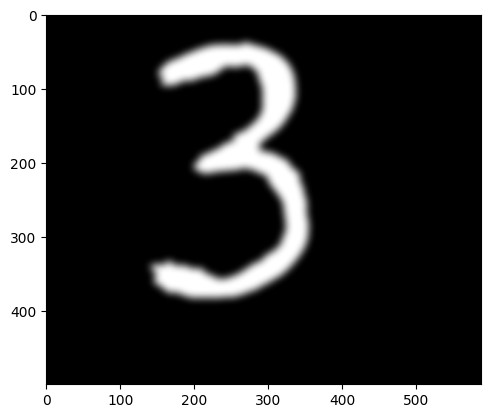

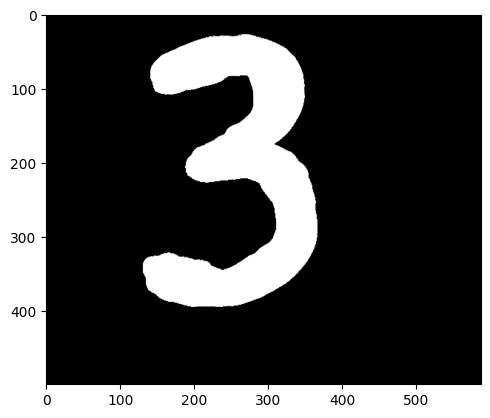

In [12]:
from torchvision.io import read_image, ImageReadMode
import matplotlib.pyplot as plt

with torch.no_grad():
    img = read_image("./sample_draw_3_blurred.png", mode=ImageReadMode.GRAY)
    img = img.to(DEVICE).float().unsqueeze(0)
    unblurred_img = model(img).squeeze()

    plt.imshow(img.squeeze().cpu().numpy(), cmap="gray")
    plt.show()
    plt.imshow(unblurred_img.cpu().numpy(), cmap="gray")
    plt.show()